# Importing

In [6]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchmetrics.regression import R2Score

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold

# Import Data

In [29]:
X, y = fetch_california_housing(as_frame=True, return_X_y=True)

# Splitting data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
print(f'x_train size:{x_train.shape}, y_train size:{y_train.shape}, \n x_test size:{x_test.shape}, y_test size{y_test.shape}')

x_train size:(14447, 8), y_train size:(14447,), 
 x_test size:(6193, 8), y_test size(6193,)


In [31]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=0)

# To Tensor

In [32]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.FloatTensor(y_train.values).unsqueeze(1)
print(f'x_train size:{x_train.shape}, y_train size:{y_train.shape}')

x_train size:torch.Size([12279, 8]), y_train size:torch.Size([12279, 1])


In [33]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.FloatTensor(y_valid.values).unsqueeze(1)
print(f'x_valid size:{x_valid.shape}, y_valid size:{y_valid.shape}')

x_valid size:torch.Size([2168, 8]), y_valid size:torch.Size([2168, 1])


In [34]:
x_test = torch.FloatTensor(x_test.values)
y_test = torch.FloatTensor(y_test.values).unsqueeze(1)
print(f'x_test size:{x_test.shape}, y_test size{y_test.shape}')

x_test size:torch.Size([6193, 8]), y_test sizetorch.Size([6193, 1])


# Normalize

In [35]:
mu = x_train.mean(dim=0)
print(mu)
print(mu.shape)

tensor([ 3.8628e+00,  2.8633e+01,  5.4168e+00,  1.0957e+00,  1.4297e+03,
         3.0534e+00,  3.5643e+01, -1.1958e+02])
torch.Size([8])


In [36]:
std = x_train.std(dim=0)
print(std)
print(std.shape)

tensor([1.8920e+00, 1.2595e+01, 2.3555e+00, 4.7635e-01, 1.1678e+03, 7.4313e+00,
        2.1419e+00, 2.0079e+00])
torch.Size([8])


In [37]:
# Standardization

x_train_st = (x_train - mu) / std
print(f' mean: {x_train_st.mean(dim=0)}, \n std: {x_train_st.std(dim=0)}')

 mean: tensor([ 6.2134e-10, -6.8036e-08, -2.3921e-08, -5.6231e-08, -9.6929e-08,
        -1.1184e-08, -1.0755e-06, -2.5798e-06]), 
 std: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [38]:
x_valid_st = (x_valid - mu) / std
print(f' mean: {x_valid_st.mean(dim=0)}, \n std: {x_valid_st.std(dim=0)}')

 mean: tensor([ 0.0139, -0.0087,  0.0193, -0.0131, -0.0256, -0.0116, -0.0399,  0.0549]), 
 std: tensor([0.9971, 1.0005, 0.7883, 0.5969, 0.8905, 0.1693, 0.9941, 0.9949])


In [39]:
x_test_st = (x_test - mu) / std
print(f'mean: {x_test_st.mean(dim=0)}, \n std: {x_test_st.std(dim=0)}')

mean: tensor([ 0.0089,  0.0046,  0.0106,  0.0111, -0.0032,  0.0118, -0.0031,  0.0031]), 
 std: tensor([1.0148, 0.9974, 1.2153, 1.0915, 0.9347, 2.1255, 0.9927, 0.9943])


# Data Loader

In [15]:
# to create mini batches from Dataset
# we need to give an object dataset to data loader: using TensorDataset

In [43]:
train_dataset = TensorDataset(x_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [44]:
valid_dataset = TensorDataset(x_valid_st, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [45]:
test_dataset = TensorDataset(x_test_st, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

# Define a model

In [67]:
in_feats = 8
out_feat = 1
h1 = 64
h2 = 16
h3 = 8
reg = nn.Sequential(nn.Linear(in_feats, h1),
                    nn.ReLU(),
                    nn.Linear(h1, h2),
                    nn.ReLU(),
                    nn.Linear(h2, out_feat))
reg = reg.to(device)

# Loss Function & Optimization

In [68]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(reg.parameters(), lr=0.05)

# Device

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [70]:
print(device)

cuda


# Utils

In [71]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Train Loop

In [72]:
num_epochs = 200
reg = reg.to(device)

loss_train_hist = []
loss_valid_hist = []

for epoch in range(num_epochs):
    # train
    loss_train = AverageMeter()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = reg(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_train.update(loss.item())

    
    with torch.no_grad():
        # validation
        loss_valid = AverageMeter()
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = reg(inputs)
            loss = loss_fn(outputs, targets)
            loss_valid.update(loss.item())
    # appending
    loss_train_hist.append(loss_train.avg)
    loss_valid_hist.append(loss_valid.avg)

    if epoch % 10 == 0:
        print(f'Epoch:{epoch}, Train loss:{loss_train.avg:.4}, Valid loss:{loss_valid.avg:.4}')
        print()

Epoch:0, Train loss:1.07, Valid loss:0.6546

Epoch:10, Train loss:0.4058, Valid loss:0.4367

Epoch:20, Train loss:0.3723, Valid loss:0.4038

Epoch:30, Train loss:0.353, Valid loss:0.3896

Epoch:40, Train loss:0.3398, Valid loss:0.3822

Epoch:50, Train loss:0.3319, Valid loss:0.3595

Epoch:60, Train loss:0.34, Valid loss:0.3538

Epoch:70, Train loss:0.3089, Valid loss:0.3435

Epoch:80, Train loss:0.3073, Valid loss:0.335

Epoch:90, Train loss:0.3062, Valid loss:0.3342

Epoch:100, Train loss:0.2972, Valid loss:0.3356

Epoch:110, Train loss:0.3158, Valid loss:0.3156

Epoch:120, Train loss:0.2938, Valid loss:0.32

Epoch:130, Train loss:0.3089, Valid loss:0.3945

Epoch:140, Train loss:0.2784, Valid loss:0.3075

Epoch:150, Train loss:0.2991, Valid loss:0.3075

Epoch:160, Train loss:0.3007, Valid loss:0.3147

Epoch:170, Train loss:0.2908, Valid loss:0.3494

Epoch:180, Train loss:0.2773, Valid loss:0.369

Epoch:190, Train loss:0.2851, Valid loss:0.3016



# Learning Curve

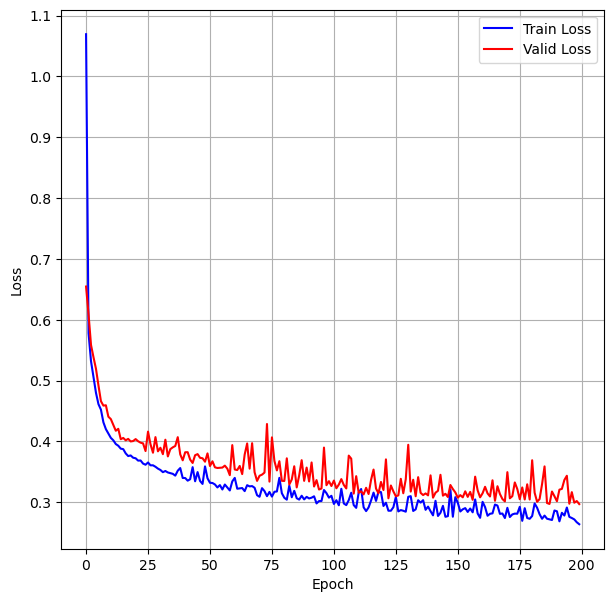

In [73]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(num_epochs), loss_train_hist, color='blue', label='Train Loss')
ax.plot(range(num_epochs), loss_valid_hist, color='red', label='Valid Loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend()

# Prediction

In [78]:
r2_score = R2Score()
x_test_st = x_test_st.to(device)
y_test = y_test.to(device)
yp_test = reg(x_test_st)

In [79]:
r2_score(yp_test, y_test)

tensor(0.7802, device='cuda:0', grad_fn=<CloneBackward0>)